In [13]:
import pandas as pd

df = pd.read_csv(r'C:\Users\srust\Downloads\data.csv')
print(df.columns.tolist())

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


Dataset size after downsampling: 14608
Train shape: (11648, 48, 11)
Test shape: (2912, 48, 11)


C:\Users\srust\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 48, 64)              │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,961 (128.75 KB)

 Trainable params: 32,961 (128.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1086 - val_loss: 0.0767
Epoch 2/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0575 - val_loss: 0.0430
Epoch 3/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0339 - val_loss: 0.0266
Epoch 4/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0225 - val_loss: 0.0187
Epoch 5/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 6/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 7/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 8/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 9/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 10/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 11/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 12/80
182/182 ━━━━━━━━━━━━━━━━━━━━ 

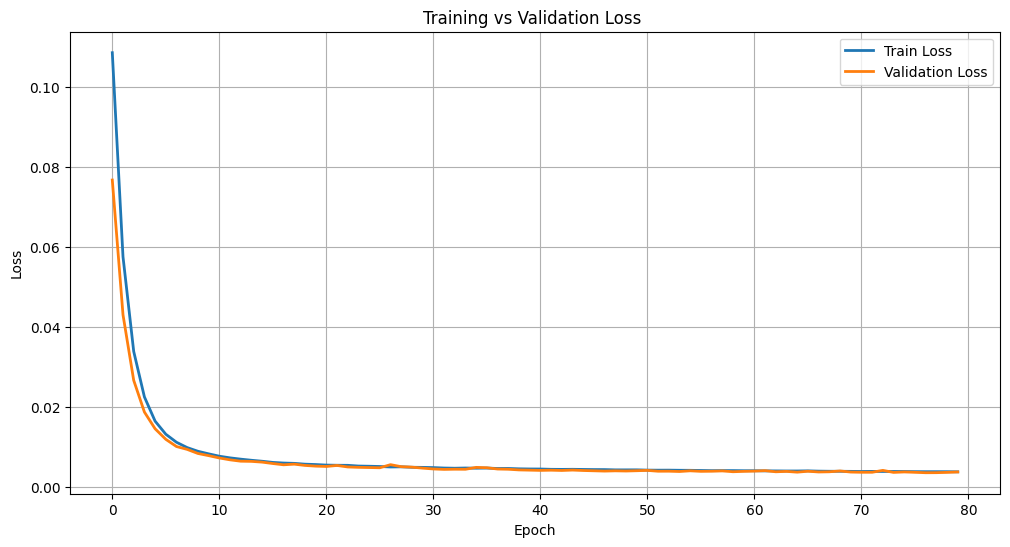

Saved loss curve to: C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM\loss_curve.png


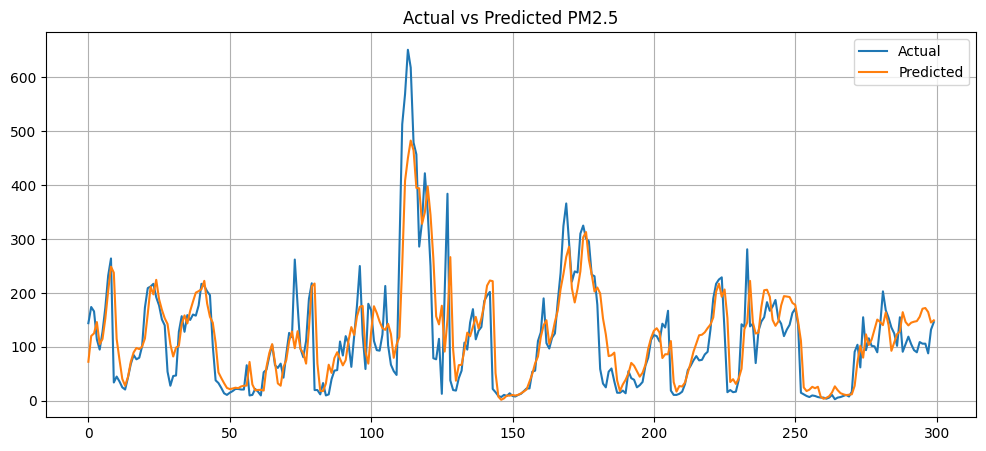

Saved prediction plot to: C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM\actual_vs_predicted.png


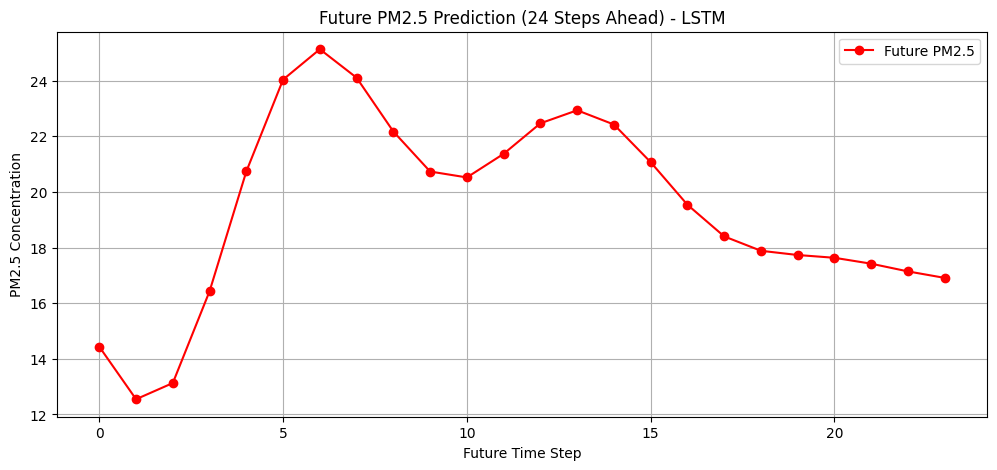

Future 24-step prediction saved successfully.


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

df = pd.read_csv(r'C:\Users\srust\Downloads\data.csv')
df = df.rename(columns={"pm2.5": "pm25"})
df = df.ffill().bfill()


df = df.iloc[::3].reset_index(drop=True)
print("Dataset size after downsampling:", len(df))


ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
cbwd_encoded = ohe.fit_transform(df[['cbwd']])
cbwd_cols = [f"cbwd_{c}" for c in ohe.categories_[0]]
df_ohe = pd.DataFrame(cbwd_encoded, columns=cbwd_cols, index=df.index)


features = ["pm25", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
data_all = pd.concat([df[features], df_ohe], axis=1)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_all.values)


look_back = 48

def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


model = Sequential([

    LSTM(64, return_sequences=True,
         kernel_regularizer=regularizers.l2(0.001),
         input_shape=(X_train.shape[1], X_train.shape[2])),  

    LSTM(32, kernel_regularizer=regularizers.l2(0.001)),

    Dense(32, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),

    Dense(1)
])



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='mse'
)

model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=80,
    batch_size=64,   
    verbose=1
)


def invert_pm25(vals):
    dummy = np.zeros((len(vals), scaled_data.shape[1]))
    dummy[:,0] = vals.flatten()
    return scaler.inverse_transform(dummy)[:,0]

y_pred = model.predict(X_test)
y_pred_inv = invert_pm25(y_pred)
y_test_inv = invert_pm25(y_test)

output_dir = r"C:\Users\srust\OneDrive\Desktop\OUTPUT LSTM"
os.makedirs(output_dir, exist_ok=True)


plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.savefig(rf"{output_dir}\loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved loss curve to:", rf"{output_dir}\loss_curve.png")


plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='Predicted')
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.legend()

plt.savefig(rf"{output_dir}\actual_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved prediction plot to:", rf"{output_dir}\actual_vs_predicted.png")


FUTURE_STEPS = 24  


last_window = scaled_data[-look_back:].copy()

future_preds_scaled = []

for _ in range(FUTURE_STEPS):
    
    last_window_reshaped = last_window.reshape(1, look_back, scaled_data.shape[1])
    
    
    next_pm25_scaled = model.predict(last_window_reshaped, verbose=0)[0, 0]
    future_preds_scaled.append(next_pm25_scaled)
    
    
    next_row = last_window[-1].copy()
    next_row[0] = next_pm25_scaled   # update PM2.5 only
    

    last_window = np.vstack([last_window[1:], next_row])


future_pm25 = invert_pm25(np.array(future_preds_scaled))


plt.figure(figsize=(12,5))
plt.plot(future_pm25, marker='o', color='red', label='Future PM2.5')
plt.title(f"Future PM2.5 Prediction ({FUTURE_STEPS} Steps Ahead) - LSTM")
plt.xlabel("Future Time Step")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.grid(True)

plt.savefig(rf"{output_dir}\future_pm25_{FUTURE_STEPS}_steps.png",
            dpi=300, bbox_inches="tight")
plt.show()

print(f"Future {FUTURE_STEPS}-step prediction saved successfully.")
